We use preprocessing functions and utilities from the earlier work done here: https://github.com/sydney-machine-learning/COVID19_sentinentanalysis

## **EDA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
import string
from textblob import TextBlob
from nltk.corpus import stopwords
!pip install demoji
nltk.download('all')
import demoji
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

     |████████████████████████████████| 42 kB 1.4 MB/s 
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading packag

In [ ]:
pd.options.display.max_colwidth = 250

In [ ]:
!pip install --upgrade transformers==4.10.1

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 636 kB 42.8 MB/s 
     |████████████████████████████████| 895 kB 50.5 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 3.3 MB 34.3 MB/s 


In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
import torchtext
from torchtext import data

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [ ]:
print(transformers.__version__)

In [ ]:
!git clone https://github.com/sydney-machine-learning/COVID19_sentinentanalysissocialmedia

Cloning into 'COVID19_sentinentanalysissocialmedia'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 309 (delta 61), reused 0 (delta 0), pack-reused 165
Receiving objects: 100% (309/309), 92.97 MiB | 16.98 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [ ]:
demoji.download_codes()

In [ ]:
senwave = pd.read_csv("/content/drive/My Drive/religious_texts/labeledEn.csv")
print("Length of Senwave Dataset = {}".format(len(senwave)))

Length of Senwave Dataset = 10000


In [ ]:
senwave.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1245138832040890370,A glass of wine keeps the corona away- DRAKE. ...,1,0,0,0,0,0,0,0,0,0,1
1,1245138859874234368,Can Anyone tell me if you took the flu shot la...,0,0,0,0,1,0,0,0,0,1,0
2,1245138869353353222,Btw producers send me beats I’m working on mus...,1,0,0,0,0,0,0,0,0,0,1
3,1245138873740648448,When someone you know.. apart of your family d...,0,0,0,0,0,1,0,0,0,0,0
4,1245138886172585989,"Dear soccer,\nI really miss you ,please come b...",0,0,0,0,0,1,1,0,0,0,0
5,1245138911195803649,new home remedy to treat coronavirus! tested b...,1,0,0,0,0,0,0,1,0,0,1
6,1245138920934969344,When Xavier Wulf does an Attack on Titan tape ...,0,0,0,0,0,0,0,0,0,0,1
7,1245138945119223814,Mouthwash is hand san for your mouth and I don...,0,0,0,0,0,1,0,0,0,1,1
8,1245138953302409216,@Sandykikimunch2 @Thomas1774Paine Yes all of t...,0,0,0,0,0,0,1,0,1,1,0
9,1245138958222311431,Update I destroyed the tire 😔 honestly if I ge...,0,0,0,1,0,1,0,0,0,0,0


[2373, 498, 389, 1325, 1695, 2133, 3492, 631, 1207, 1820, 4476]


Text(0.5, 0, 'Count')

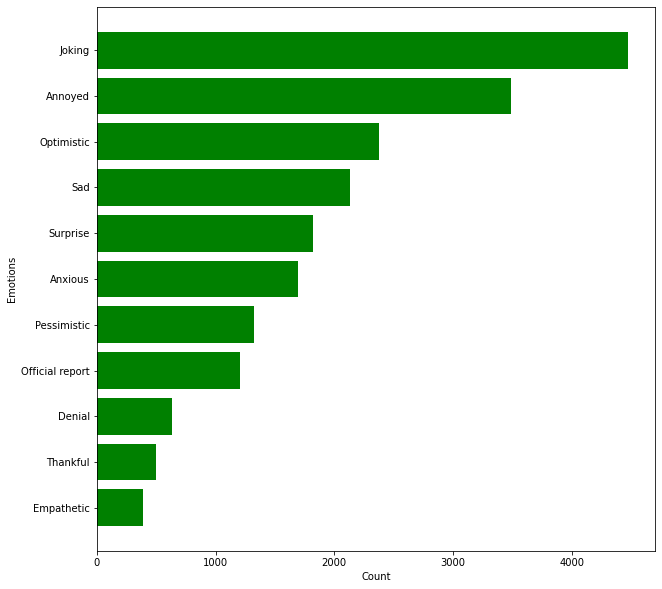

In [ ]:
emotions = list(senwave.columns[2:])
scores = [sum(senwave[x]) for x in emotions]
print(scores)
pairs = []

for i in range(len(emotions)):
    pairs.append((emotions[i], scores[i]))

pairs = sorted(pairs, key = lambda x : x[1], reverse = False)
emotions_sorted = []
scores_sorted = []

for pair in pairs:
    emotions_sorted.append(pair[0])
    scores_sorted.append(pair[1])

fig = plt.figure(figsize = (10, 10))
plt.barh(emotions_sorted, scores_sorted, color = 'green')
plt.ylabel("Emotions")
plt.xlabel("Count")

In [ ]:
rand_idx = np.random.randint(0, len(senwave))
print("Tweet : ", senwave.iloc[rand_idx]['Tweet'])
for e in emotions:
    print(e, ": ", senwave.iloc[rand_idx][e])

Tweet :  Stay home . Keep away from  covid  19 . We will follow your instructions to avoid covid 19 .
Optimistic :  1
Thankful :  0
Empathetic :  0
Pessimistic :  0
Anxious :  0
Sad :  0
Annoyed :  0
Denial :  0
Official report :  1
Surprise :  0
Joking :  0


In [ ]:
only_emotes = senwave[emotions]

In [ ]:
only_emotes

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,0,0,0,0,0,0,1
9996,1,1,0,0,1,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,1,0
9998,1,0,0,1,0,0,0,0,0,0,1


In [ ]:
emote_array = np.zeros((11, 11))
e2i = {
    'Optimistic' : 0, 'Thankful' : 1, 'Empathetic' : 2, 'Pessimistic' : 3, 'Anxious' : 4, 'Sad' : 5, 'Annoyed' : 6, 'Denial' : 7, 'Official report' : 8,
    'Surprise' : 9, 'Joking' : 10
}
for i in range(len(only_emotes)):
    l = only_emotes.iloc[i].tolist()
    for j in range(11):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 11):                 # to avoid double counting.
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

In [ ]:
emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)
emote_df

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,2373,235,171,226,246,291,379,72,156,387,982
1,235,498,28,15,41,29,67,14,70,98,92
2,171,28,389,18,50,71,41,7,7,24,63
3,226,15,18,1325,268,272,420,90,62,264,554
4,246,41,50,268,1695,360,452,95,138,357,510
5,291,29,71,272,360,2133,723,54,186,299,747
6,379,67,41,420,452,723,3492,261,122,536,1235
7,72,14,7,90,95,54,261,631,51,201,184
8,156,70,7,62,138,186,122,51,1207,284,95
9,387,98,24,264,357,299,536,201,284,1820,612


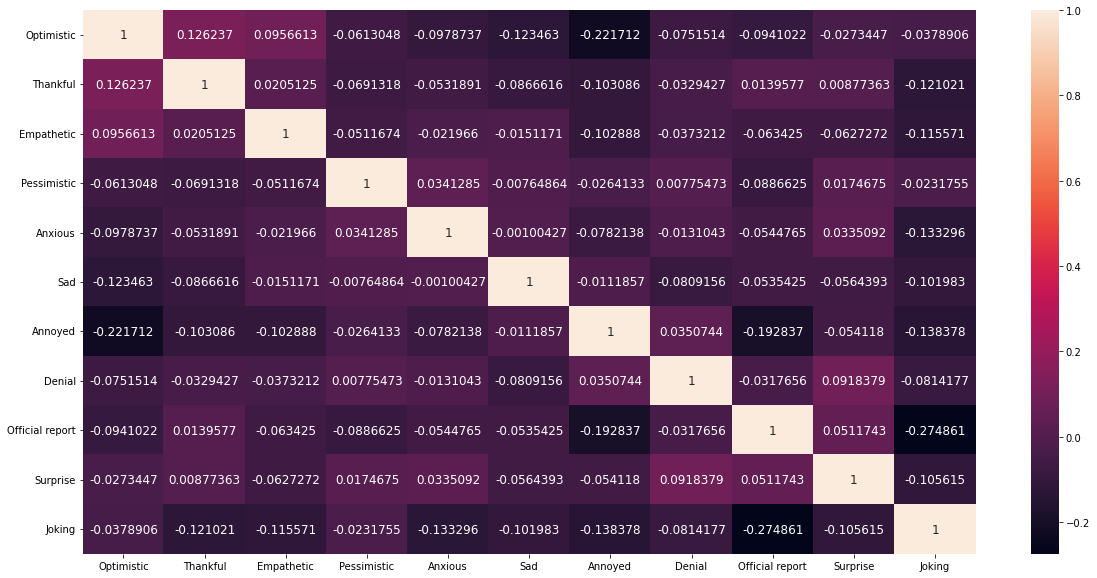

In [ ]:
fig = plt.figure(figsize = (20, 10))
sns.heatmap(only_emotes.corr(), annot = True, xticklabels = emote_df.columns, yticklabels = emote_df.columns, fmt = 'g', annot_kws = {"size" : 12})

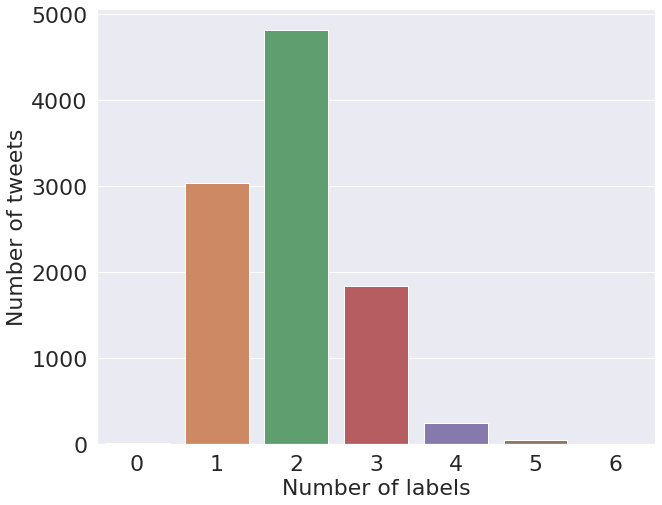

In [ ]:
senwave['n_emotions'] = senwave['Optimistic'] + senwave['Thankful'] + senwave['Empathetic'] + senwave['Pessimistic'] + senwave['Anxious'] + senwave['Sad'] + senwave['Annoyed'] + \
                        senwave['Official report'] + senwave['Surprise'] + senwave['Joking']
rowSums = senwave['n_emotions']
multiLabel_counts = rowSums.value_counts()

sns.set(font_scale = 2)
plt.figure(figsize = (10, 8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values, orient = 'v')

#plt.title("Tweets having multiple labels")
plt.ylabel('Number of tweets', fontsize = 22)
plt.xlabel('Number of labels', fontsize = 22)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    #ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
multiLabel_counts

2    4818
1    3034
3    1842
4     244
5      46
0      15
6       1
Name: n_emotions, dtype: int64

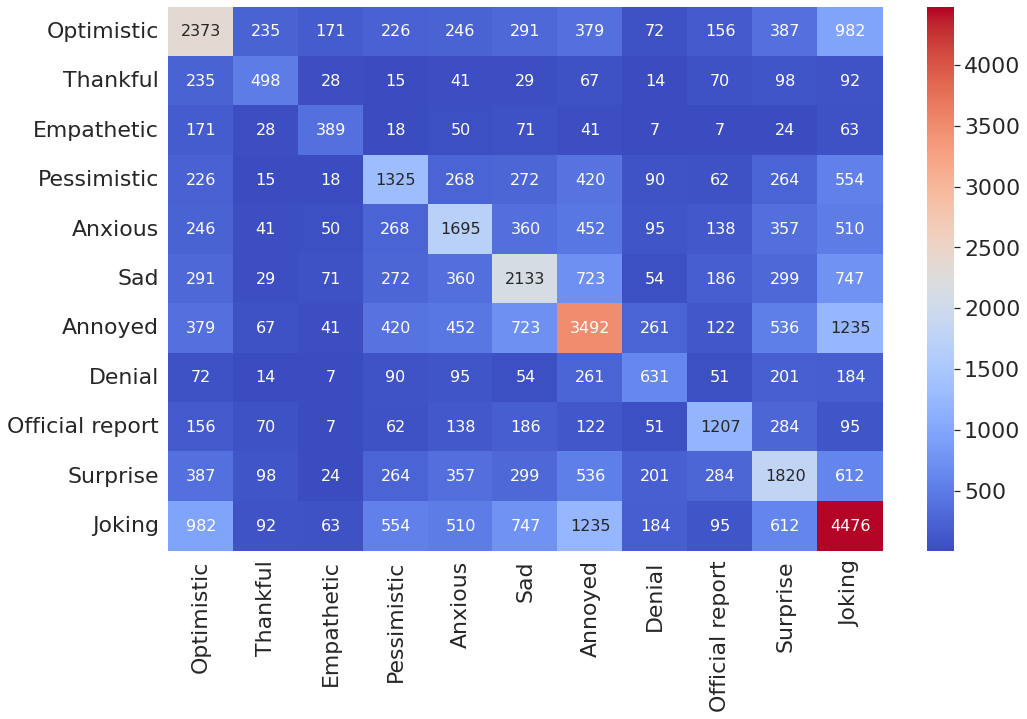

In [ ]:
fig = plt.figure(figsize = (16,10))
sns.set(font_scale = 2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns, 
            fmt = 'g', annot_kws = {"size" : 16})

**Cleaning followed by Unigram and Bigram analysis**

In [ ]:
def clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    StopWords = stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in StopWords]

In [ ]:
words = clean(''.join(str(senwave['Tweet'].tolist())))

In [ ]:
words[:20]

['glass',
 'wine',
 'keep',
 'corona',
 'away',
 'drake',
 'se',
 'diga',
 'ma',
 'cheer',
 'anyone',
 'tell',
 'took',
 'flu',
 'shot',
 'last',
 'year',
 'give',
 'positive',
 'result']

# **Preprocessing**

In [ ]:
contractions = { 
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
"couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
"hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
"i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
"ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
"mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she shall / she will",
"she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
"so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
"they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
"we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
"y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
"you're": "you are", "you've": "you have"
}

In [ ]:
contractionsWithAnotherInvertedComma = { 
"ain’t": "am not", "aren’t": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not",
"couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
"hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "he’s": "he is",
"how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
"i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would",
"it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us",
"ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
"mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have",
"shan’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will",
"she’ll’ve": "she will have", "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
"so’ve": "so have", "so’s": "so is", "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would",
"there’d’ve": "there would have", "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will",
"they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would",
"we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have",
"who’s": "who is", "who’ve": "who have", "why’s": "why is", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",
"would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have",
"y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
"you’re": "you are", "you’ve": "you have"
}

In [ ]:
class preprocess():
    def __init__(self, df, contractions, otherContractions):
        self.df = df
        self.contractions = contractions
        self.otherContractions = otherContractions
    
    def lower(self, tweet):
        return tweet.lower()
    
    def abbreviate(self, tweet):
        tweet = tweet.split(' ')
        j = 0
        for str_ in tweet:
            fileName = '/content/drive/My Drive/religious_texts/Abbreviations.txt'
            accessMode = 'r'
            with open(fileName, accessMode) as csvfile:
                dataFromFile = csv.reader(csvfile, delimiter = '=')
                str_ = re.sub('[^a-zA-Z0-9-_.]', '', str_)
                for row in dataFromFile:
                    if str_.upper() == row[0]:
                        tweet[j] = row[1]
                csvfile.close()
            j += 1
        return ' '.join(tweet)
    
    def expand(self, tweet):
        for word in tweet.split():
            if word in self.contractions.keys():
                tweet = tweet.replace(word, self.contractions[word])
            elif word in self.otherContractions.keys():
                tweet = tweet.replace(word, self.otherContractions[word])
        return tweet
    
    def emoji2text(self, tweet):
        emojis = demoji.findall(tweet)
        new_tweet = []
        for word in tweet.split():
            if word in emojis.keys():
                tweet = tweet.replace(word, emojis[word])
                new_tweet.append(emojis[word])
            wordmojis = demoji.findall(word)
            for char in word:
                if char in wordmojis.keys():
                    tweet = tweet.replace(word, wordmojis[char])
        
        return tweet

    def remove_hashtags(self, tweet):
        return re.sub(r'\#w+', '', tweet)
    
    def remove_mentions(self, tweet):
        for word in tweet.split():
            if word[0] == '@':
                tweet = tweet.replace(word, '')
        return tweet

    def remove_punctuations(self, tweet):
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        return tweet.translate(trantab)
    
    def preprocess_tweet(self, tweet):
        tweet = self.lower(tweet)
        tweet = self.abbreviate(tweet)
        tweet = self.expand(tweet)
        tweet = self.emoji2text(tweet)
        tweet = self.remove_mentions(tweet)
        tweet = self.remove_hashtags(tweet)
        tweet = self.remove_punctuations(tweet)
        return tweet

In [ ]:
# from COVID19_sentinentanalysissocialmedia.preprocessing.preprocess import preprocess
pp_class = preprocess(senwave, contractions, contractionsWithAnotherInvertedComma)
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : pp_class.preprocess_tweet(x))

In [ ]:
senwave['Tweet'] = senwave['Tweet'].str.lower()
senwave.head(10)

In [ ]:
from COVID19_sentinentanalysissocialmedia.preprocessing import wordReplace
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : wordReplace.bruteGen(x))

# **Building the model followed by training & testing**

In [ ]:
from sklearn.model_selection import train_test_split
sen_train, sen_test = train_test_split(senwave, train_size = 0.9, random_state = 1024)

sen_train.to_csv("train.csv", index = False)
sen_test.to_csv("test.csv", index = False)

In [ ]:
sen_train.head(1)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking,n_emotions
560,1245143836667432960,minister for agriculture mahendra reddy to hol...,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

TWEET = torchtext.legacy.data.Field(sequential = True, lower = True, tokenize = tokenizer)
LABEL = torchtext.legacy.data.Field(sequential = False, use_vocab = False)

dataFields = [("ID", None), ("Tweet", TWEET), ("Optimistic", LABEL), ("Thankful", LABEL),
              ("Empathetic", LABEL), ("Pessimistic", LABEL), ("Anxious", LABEL), ("Sad", LABEL),
              ("Annoyed", LABEL), ("Denial", LABEL), ("Official report", LABEL),
              ("Surprise", LABEL), ("Joking", LABEL)]

train_dataset, test_dataset = torchtext.legacy.data.TabularDataset.splits(
    path = '/content/', train = 'train.csv', test = 'test.csv', format = 'csv', fields = dataFields, skip_header = True
    )

In [ ]:
print("Number of training samples : {}\n Number of testing samples : {}".format(len(train_dataset), len(test_dataset)))

Number of training samples : 9000
 Number of testing samples : 1000


#**Using BERT**

In [ ]:
df = senwave.drop(['ID'], axis = 1)
df['list'] = df[df.columns[1:12]].values.tolist()
new_df = df[['Tweet', 'list']].copy()
new_df.head()

,Tweet,list
0,a glass of wine keeps the corona away drake ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,can anyone tell me if you took the flu shot la...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]"
2,by the way producers send me beats i am workin...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,when someone you know apart of your family d...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,dear soccer \ni really miss you please come b...,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]"


**Preparing the dataset**

In [ ]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            pad_to_max_length = True,
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'targets' : torch.tensor(self.targets[index], dtype = torch.float)
        }

In [ ]:
train_dataset = sen_train.drop(['ID'], axis = 1)
train_dataset['list'] = train_dataset[train_dataset.columns[1:12]].values.tolist()
train_df = train_dataset[['Tweet', 'list']].copy()
train_df = train_df.reset_index(drop = True)

test_dataset = sen_test.drop(['ID'], axis = 1)
test_dataset['list'] = test_dataset[test_dataset.columns[1:12]].values.tolist()
test_df = test_dataset[['Tweet', 'list']].copy()
test_df = test_df.reset_index(drop = True)

In [ ]:
training_set = CustomDataset(train_df, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_df, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

**Creating the Transformer model**

In [ ]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 11)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

**Fine Tuning**

In [ ]:
def train(epoch):
    model.train()
    total_loss = 0

    for unw, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids, return_dict = False)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()

        if unw % 2000 == 0:
            print(f'Iter : {unw+1}, Epoch: {epoch+1}, Loss: {total_loss/(unw+1)}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
EPOCHS = 4
for epoch in range(EPOCHS):
    train(epoch)

**Validating the data**

In [ ]:
def valid():
    model.eval()
    req_targets = []
    req_outputs = []
    valid_loss = 0

    with torch.no_grad():
        for unw, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            valid_loss += loss.item()

            req_targets.extend(targets.cpu().detach().numpy().tolist())
            req_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    valid_loss /= len(testing_loader)
    return req_outputs, req_targets, valid_loss

In [ ]:
from sklearn import metrics

outputs, targets, valid_loss = valid()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
outputs = np.array(outputs)
targets = np.array(targets)

In [ ]:
int_outputs = np.zeros((outputs.shape[0], outputs.shape[1]))

for row in range(outputs.shape[0]):
    for col in range(outputs.shape[1]):
        if outputs[row][col] >= 0.5: int_outputs[row][col] = 1

In [ ]:
targets[0], int_outputs[0], outputs[0]

(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]),
 array([0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.]),
 array([0.45169118, 0.51452482, 0.49083784, 0.56770641, 0.53967065,
        0.50234669, 0.57243228, 0.56707716, 0.42979756, 0.3855066 ,
        0.51762992]))

In [ ]:
bert_ham_loss = hamming_loss(targets, int_outputs)
bert_jacc_score = jaccard_score(targets, int_outputs, average = 'samples')
bert_lrap = label_ranking_average_precision_score(targets, outputs)
bert_f1_macro = f1_score(targets, int_outputs, average = 'macro')
bert_f1_micro = f1_score(targets, int_outputs, average = 'micro')

In [ ]:
print("Test Loss:", valid_loss)
print("Hamming Loss:", bert_ham_loss)
print("Jaccard Score:", bert_jacc_score)
print("Label Ranking Average Precision Score:", bert_lrap)
print("F1 Macro Score:", bert_f1_macro)
print("F1 Micro Score:", bert_f1_micro)

Test Loss: 0.7174893503189087
Hamming Loss: 0.5591818181818182
Jaccard Score: 0.18250321067821068
Label Ranking Average Precision Score: 0.3700368139730635
F1 Macro Score: 0.21934729484693127
F1 Micro Score: 0.2982316029663434


Results:


1.   lr = 1e-03: bce loss: 0.432, hamming loss: 0.183, jacc score: 0, lrap: 0.5659, f1 macro: 0, f1 micro: 0
2.   lr = 1e-04: bce loss: 0.432, hamming loss: 0.183, jacc score: 0, lrap: 0.5275, f1 macro: 0, f1 micro: 0
3.   lr = 1e-05: bce loss: 0.372, hamming loss: 0.142, jacc score: 0.5096, lrap: 0.766, f1 macro: 0.53, f1 micro: 0.587 



In [ ]:
torch.save(model, f = '/content/drive/MyDrive/religious_texts/bertmodel.pth')